In [1]:
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'

import tensorflow as tf
from keras.losses import binary_crossentropy
from keras import backend as K
from keras import optimizers
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model

import sys
import hdf5storage
import numpy as np
import cv2
import matplotlib.pyplot as plt
import segmentation_models as sm
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import gc

tf.keras.backend.set_image_data_format('channels_last')

Segmentation Models: using `tf.keras` framework.


In [17]:
# Adopted from https://github.com/adityajn105/brain-tumor-segmentation-unet

## Download and prepare dataset

In [23]:
# download the dataset
!wget -O temp.zip -q https://ndownloader.figshare.com/articles/1512427/versions/5

# unzip the dataset and delete the zip
!unzip -q temp.zip && rm temp.zip

# concatenate the multiple zipped data in a single zip
!cat brainTumorDataPublic_* > brainTumorDataPublic_temp.zip
!zip -FF brainTumorDataPublic_temp.zip --out data.zip > progress.txt

# remove the temporary files
!rm brainTumorDataPublic_*

# unzip the full archive and delete it 
!unzip -q data.zip -d data && rm data.zip

# check that "data" contains 3064 files
!ls data | wc -l

3064


In [25]:
"""
Read all the Matlab files in the 'data' directory and export 3 numpy arrays:
- labels.npy
- images.npy
- masks.npy
Usage: python matlab_to_numpy.py ~/brain_tumor_dataset
"""

class NoDataFound(Exception):
    pass


def dir_path(path):
    """Check the path and the existence of a data directory"""
    # replace '\' in path for Windows users
    path = path.replace('\\', '/')
    data_path = os.path.join(path, 'data').replace('\\', '/')

    if os.path.isdir(data_path):
        return path
    elif os.path.isdir(path):
        raise NoDataFound('Could not find a "data" folder inside directory. {} does not exist.'
                          .format(data_path))
    else:
        raise NotADirectoryError(path)


DATASET_PATH = ""
image_dimension = 512

labels = []
images = []
masks = []

data_dir = os.path.join(DATASET_PATH, 'data').replace('\\', '/')
files = os.listdir(data_dir)
for i, file in enumerate(files, start=1):
    if i % 10 == 0:
        # print the percentage of images loaded
        sys.stdout.write('\r[{}/{}] images loaded: {:.1f} %'
                         .format(i, len(files), i / float(len(files)) * 100))
        sys.stdout.flush()

    # load matlab file with hdf5storage as scipy.io.loadmat does not support v7.3 files
    mat_file = hdf5storage.loadmat(os.path.join(data_dir, file))['cjdata'][0]

    # resize image and mask to a unique size
    image = cv2.resize(mat_file[2], dsize=(image_dimension, image_dimension),
                       interpolation=cv2.INTER_CUBIC)
    mask = cv2.resize(mat_file[4].astype('uint8'), dsize=(image_dimension, image_dimension),
                      interpolation=cv2.INTER_CUBIC)

    labels.append(int(mat_file[0]))
    images.append(image)
    masks.append(mask.astype(bool))

sys.stdout.write('\r[{}/{}] images loaded: {:.1f} %'
                 .format(i, len(files), i / float(len(files)) * 100))
sys.stdout.flush()

labels = np.array(labels)
images = np.array(images)
masks = np.array(masks)

print('\nlabels:', labels.shape)
print('images:', images.shape)
print('masks:', masks.shape)

np.save(os.path.join(DATASET_PATH, 'labels.npy'), labels)
np.save(os.path.join(DATASET_PATH, 'images.npy'), images)
np.save(os.path.join(DATASET_PATH, 'masks.npy'), masks)

del images
del masks
del labels
gc.collect()

print('labels.npy, images.npy, masks.npy saved in', DATASET_PATH)

[3064/3064] images loaded: 100.0 %
labels: (3064,)
images: (3064, 512, 512)
masks: (3064, 512, 512)
labels.npy, images.npy, masks.npy saved in 


In [27]:
integer_to_class = {'1': 'meningioma (1)', '2': 'glioma (2)', '3': 'pituitary tumor (3)'}

##Load images, labels, masks
labels = np.load('labels.npy')
images = np.clip((np.load('images.npy')/12728), 0, 1)
masks = np.load('masks.npy') * 1
print(labels.shape)
print(images.shape)
print(masks.shape)

(3064,)
(3064, 512, 512)
(3064, 512, 512)


In [28]:
img_size_ori = 512
img_size_target = 128

images = np.expand_dims(images,axis=-1)
masks = np.expand_dims(masks,axis=-1)

def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True,)
    
def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
  
images = np.array([ downsample(image) for image in images ])
masks = (np.array([ downsample(mask) for mask in masks ])>0)*1

print(images.shape)
print(masks.shape)  

(3064, 128, 128, 1)
(3064, 128, 128, 1)


[ 708 1426  930]


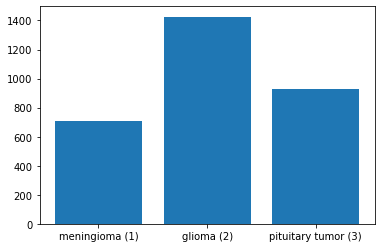

In [29]:
classes, counts = np.unique(labels, return_counts=True)
plt.bar(classes,counts,tick_label=list(integer_to_class.values()))
print(counts)

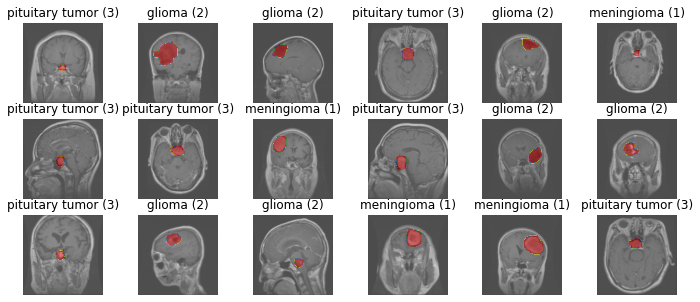

In [30]:
plt.figure(figsize=(12, 5))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow( np.squeeze(images[idx],axis=-1), cmap='gray')
    plt.imshow( np.squeeze(np.ones_like(masks[idx])-masks[idx],axis=-1), alpha=0.5, cmap='Set1')
    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')

### Train Image and its mask which is to be predicted

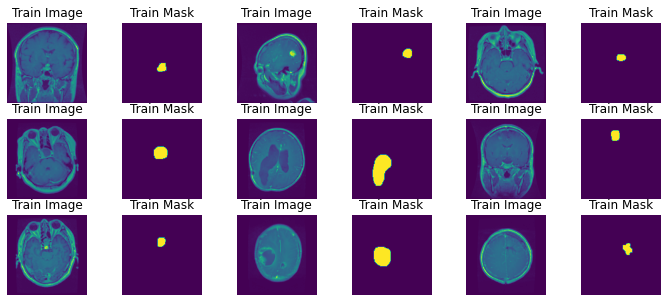

In [32]:
plt.figure(figsize=(12, 5))
i=1
for idx in np.random.randint( images.shape[0], size=9):
    plt.subplot(3,6,i);i+=1
    plt.imshow( np.squeeze(images[idx],axis=-1))
    plt.title("Train Image")
    plt.axis('off')
    plt.subplot(3,6,i);i+=1
    plt.imshow( np.squeeze(masks[idx],axis=-1)) 
    plt.title("Train Mask")
    plt.axis('off')

In [33]:
images = images.astype(np.float32)
masks = masks.astype(np.float32)

X, X_val, Y, Y_val = train_test_split(images, masks, test_size=0.2, stratify=labels)
del images
del masks
del labels
gc.collect()
X.shape,X_val.shape

((2451, 128, 128, 1), (613, 128, 128, 1))

### Augmentation

In [34]:
X = np.append( X, [ np.fliplr(x) for x in X], axis=0 )
Y = np.append( Y, [ np.fliplr(y) for y in Y], axis=0 )
X.shape,Y.shape

((4902, 128, 128, 1), (4902, 128, 128, 1))

In [35]:
train_image_datagen = ImageDataGenerator(rotation_range=20,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         width_shift_range=0.1,
                                         height_shift_range=0.1,
                                         shear_range=0.2,
                                         zoom_range=0.1,
                                         brightness_range=[0.9,1.1])

train_label_datagen = ImageDataGenerator(rotation_range=20,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         width_shift_range=0.1,
                                         height_shift_range=0.1,
                                         shear_range=0.2,
                                         zoom_range=0.1,
                                         brightness_range=[0.9,1.1])

val_image_datagen = ImageDataGenerator()
val_label_datagen = ImageDataGenerator()

train_image_generator = train_image_datagen.flow(X, batch_size=32, shuffle=True)
train_label_generator = train_label_datagen.flow(Y, batch_size=32, shuffle=True)

train_image_generator = val_image_datagen.flow(X_val, batch_size=32, shuffle=False)
train_label_generator = val_label_datagen.flow(Y_val, batch_size=32, shuffle=False)

train_generator = zip(train_image_generator, train_label_generator)
val_generator = zip(train_image_generator, train_label_generator)

### Defining IOU metric and compile Model

In [36]:
model = sm.Unet('resnet34', classes=1, encoder_weights=None, activation='sigmoid', input_shape=(128, 128, 1))

optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(optimizer=optimizer, loss=sm.losses.bce_dice_loss, metrics=['accuracy', sm.metrics.iou_score])

/home/batselem/anaconda3/envs/tf2/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
model_checkpoint = ModelCheckpoint('model_best_checkpoint.h5', save_best_only=True, 
                                    monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
reduceLR = ReduceLROnPlateau(patience=10, verbose=2, monitor='val_loss', min_lr=1e-3, mode='min')
callbacks = [early_stopping, reduceLR, model_checkpoint]

hist = model.fit(X, Y, batch_size=32, epochs=100, validation_data=(X_val,Y_val), verbose=1, callbacks=callbacks)

Epoch 1/100


2022-07-08 15:34:28.651631: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8401
2022-07-08 15:34:29.571484: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


154/154 [==============================] - ETA: 0s - loss: 0.8059 - accuracy: 0.9617 - iou_score: 0.2074
Epoch 00001: val_loss improved from inf to 3.42334, saving model to model_best_checkpoint.h5


/home/batselem/anaconda3/envs/tf2/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


154/154 [==============================] - 24s 114ms/step - loss: 0.8059 - accuracy: 0.9617 - iou_score: 0.2074 - val_loss: 3.4233 - val_accuracy: 0.9574 - val_iou_score: 5.5986e-10 - lr: 0.0010
Epoch 2/100
153/154 [============================>.] - ETA: 0s - loss: 0.5028 - accuracy: 0.9808 - iou_score: 0.4042
Epoch 00002: val_loss improved from 3.42334 to 1.19861, saving model to model_best_checkpoint.h5
154/154 [==============================] - 16s 103ms/step - loss: 0.5029 - accuracy: 0.9808 - iou_score: 0.4038 - val_loss: 1.1986 - val_accuracy: 0.9080 - val_iou_score: 0.0578 - lr: 0.0010
Epoch 3/100
153/154 [============================>.] - ETA: 0s - loss: 0.4180 - accuracy: 0.9840 - iou_score: 0.4803
Epoch 00003: val_loss improved from 1.19861 to 0.78460, saving model to model_best_checkpoint.h5
154/154 [==============================] - 16s 104ms/step - loss: 0.4181 - accuracy: 0.9840 - iou_score: 0.4798 - val_loss: 0.7846 - val_accuracy: 0.9691 - val_iou_score: 0.2211 - lr: 0.

Epoch 23/100
153/154 [============================>.] - ETA: 0s - loss: 0.1395 - accuracy: 0.9945 - iou_score: 0.7907
Epoch 00023: val_loss did not improve from 0.23758
154/154 [==============================] - 14s 89ms/step - loss: 0.1395 - accuracy: 0.9945 - iou_score: 0.7908 - val_loss: 0.2539 - val_accuracy: 0.9913 - val_iou_score: 0.6565 - lr: 0.0010
Epoch 24/100
153/154 [============================>.] - ETA: 0s - loss: 0.1394 - accuracy: 0.9945 - iou_score: 0.7909
Epoch 00024: val_loss did not improve from 0.23758
154/154 [==============================] - 14s 89ms/step - loss: 0.1394 - accuracy: 0.9945 - iou_score: 0.7907 - val_loss: 0.2406 - val_accuracy: 0.9914 - val_iou_score: 0.6668 - lr: 0.0010
Epoch 25/100
153/154 [============================>.] - ETA: 0s - loss: 0.1255 - accuracy: 0.9950 - iou_score: 0.8093
Epoch 00025: val_loss did not improve from 0.23758
154/154 [==============================] - 14s 89ms/step - loss: 0.1255 - accuracy: 0.9950 - iou_score: 0.8094 - 

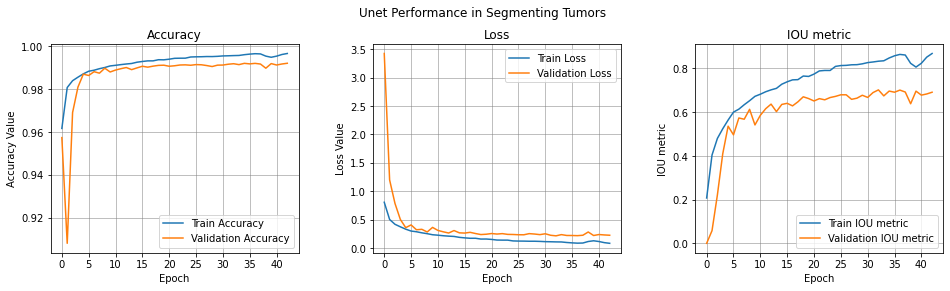

In [12]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
t = f.suptitle('Unet Performance in Segmenting Tumors', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = hist.epoch

ax1.plot(epoch_list, hist.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, hist.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('Accuracy Value');ax1.set_xlabel('Epoch');ax1.set_title('Accuracy')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, hist.history['loss'], label='Train Loss')
ax2.plot(epoch_list, hist.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('Loss Value');ax2.set_xlabel('Epoch');ax2.set_title('Loss')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3.plot(epoch_list, hist.history['iou_score'], label='Train IOU metric')
ax3.plot(epoch_list, hist.history['val_iou_score'], label='Validation IOU metric')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('IOU metric');ax3.set_xlabel('Epoch');ax3.set_title('IOU metric')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)

In [13]:
custom_objects = {'binary_crossentropy_plus_dice_loss': sm.losses.bce_dice_loss,
                                           'iou_score': sm.metrics.iou_score}
model = load_model('model_best_checkpoint.h5', custom_objects=custom_objects)

In [14]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def get_iou_vector(A, B):
    t = A>0
    p = B>0
    intersection = np.logical_and(t,p)
    union = np.logical_or(t,p)
    iou = (np.sum(intersection) + 1e-10 )/ (np.sum(union) + 1e-10)
    return iou
  
def getIOUCurve(mask_org,predicted):
    thresholds = np.linspace(0, 1, 100)
    ious = np.array([get_iou_vector(mask_org, predicted > threshold) for threshold in thresholds])
    thres_best_index = np.argmax(ious[9:-10]) + 9
    iou_best = ious[thres_best_index]
    thres_best = thresholds[thres_best_index]
    return thresholds,ious,iou_best,thres_best

Text(0.5, 1.0, 'Threshold vs IoU (0.768, 0.856)')

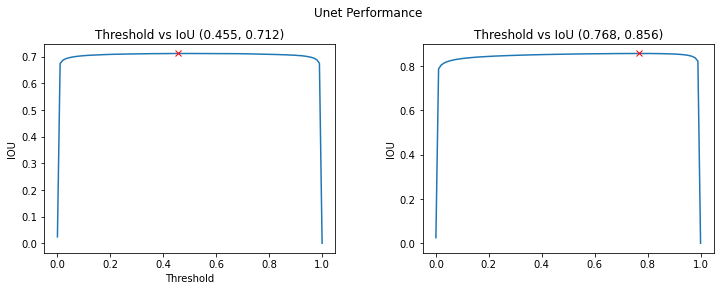

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Unet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

th, ious, iou_best, th_best = getIOUCurve(Y_val,model.predict(X_val))
ax1.plot(th, ious,label="For Validation")
ax1.plot(th_best, iou_best, "xr", label="Best threshold")
ax1.set_ylabel('IOU');ax1.set_xlabel('Threshold')
ax1.set_title("Threshold vs IoU ({:.3f}, {:.3f})".format(th_best, iou_best))

th, ious, iou_best, th_best = getIOUCurve(Y,model.predict(X))
ax2.plot(th, ious, label="For Training")
ax2.plot(th_best, iou_best, "xr", label="Best threshold")
ax2.set_ylabel('IOU');ax1.set_xlabel('Threshold')
ax2.set_title("Threshold vs IoU ({:.3f}, {:.3f})".format(th_best, iou_best))

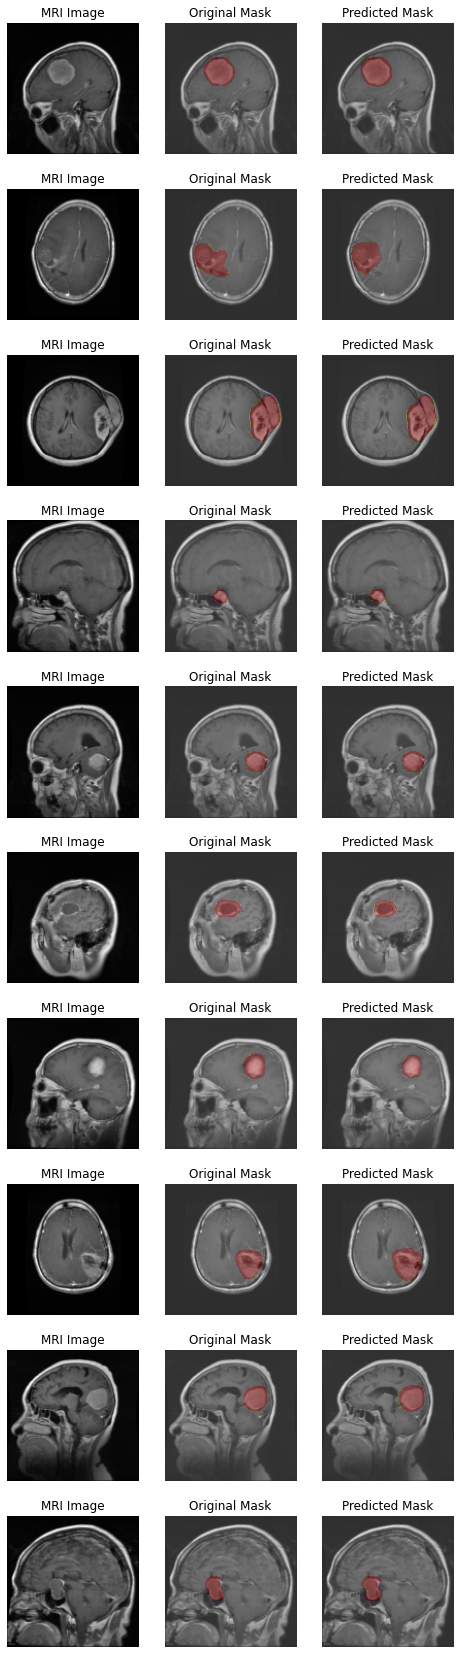

In [16]:
THRESHOLD = 0.2
predicted_mask = (model.predict(X_val)>THRESHOLD)*1

plt.figure(figsize=(8,30))
i=1;total=10
temp = np.ones_like( Y_val[0] )
for idx in np.random.randint(0,high=X_val.shape[0],size=total):
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_val[idx],axis=-1), cmap='gray' )
    plt.title("MRI Image");plt.axis('off')
    
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_val[idx],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(temp - Y_val[idx],axis=-1), alpha=0.3, cmap='Set1' )
    plt.title("Original Mask");plt.axis('off')
    
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_val[idx],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(temp - predicted_mask[idx],axis=-1), alpha=0.3, cmap='Set1' )
    plt.title("Predicted Mask");plt.axis('off')